# Pruning

このハンズオンでは、modelのpruningを行い、得られる効果を確認していきます。

In [1]:
%pip install -q tensorflow-model-optimization

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tempfile
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import os
import zipfile

2023-04-10 10:07:28.044446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 10:07:30.652872: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-04-10 10:07:30.653003: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

### データセットの準備
評価で使用するため、再度Fashion-MNISTデータセットをロードして、
前処理も行なっておきます。

In [3]:
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = fashion_mnist.load_data()

## shapeを(batch_size, rows, cols, channels)にexpandする
X_train = np.expand_dims(X_train_orig, -1)
X_test = np.expand_dims(X_test_orig, -1)

print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

## グレースケールの 0-255 の値を 正規化して 0-1 の浮動小数にする
X_train = X_train / 255.0
X_test = X_test / 255.0

## one hot vectorにする
y_train = tf.keras.utils.to_categorical(y_train_orig, 10)
y_test = tf.keras.utils.to_categorical(y_test_orig, 10)

print("one hot label shape", y_train.shape)

X_train shape (60000, 28, 28, 1)
X_test shape (10000, 28, 28, 1)
one hot label shape (60000, 10)


### モデルのロード
01で保存したFashion-MNISTモデルをロードします

In [4]:
# 01の学習によってgpuのプロセスが残っている場合は、消去する
!nvidia-smi

Mon Apr 10 10:07:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W /  70W |      0MiB / 15360MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
#!kill <<PIDを指定>>

In [6]:
## <todo> 自分の名前を入力してください
USER    = "___" # 自分の名前
BUCKET  = "mixi-ml-handson-2023"
VERSION = "001"

base_model = tf.keras.models.load_model("gs://{}/{}/{}".format(BUCKET, USER, VERSION))

# ベースモデルを一時保存しておく
_, base_model_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(base_model, base_model_file, include_optimizer=False)

2023-04-10 10:07:57.468292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-10 10:07:57.480524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-10 10:07:57.482225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-10 10:07:57.484465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

### ベースモデルの精度確認
再度、ベースモデルの評価を確認してみます。

In [7]:
loss, accuracy = base_model.evaluate(X_test, y_test, batch_size=16)
print("loss: {}, Accuracy: {}".format(loss, accuracy))

2023-04-10 10:08:04.138631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200


313/313 [==============================] - 3s 3ms/step - loss: 0.2372 - categorical_accuracy: 0.9252


[0.2372296154499054, 0.9251999855041504]

### 重みの確認

pruningとは、重みが小さいエッジを取り去って、パラメータを削減する手法です。  
パラメータが少なくなれば、その分モデルのサイズは小さくなり、高速化されます。  
しかし、今回のモデルの重みに削減する余地はあるでしょうか。

実際に重みの値を確認してみましょう。

まず、再度モデルの構成を確認します。

In [8]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 10, 10, 64)        0         
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                        

この中のうち、`conv2d`と`dense`が層を構成しています。  
これらの層の重みからヒストグラムを作成してみましょう。

In [9]:
import matplotlib.pyplot as plt

def draw_weights_histgram(model, layers_index, bins=1000):
    weight_list = model.layers[layers_index].weights[0].numpy().flatten()
    plt.hist(weight_list, bins=bins)


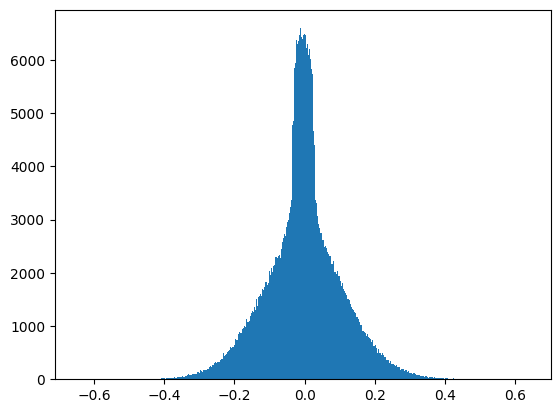

In [10]:
# conv2dまたはdense層のindexを入れて、それぞれの重みをplotしてみましょう
draw_weights_histgram(base_model, 6)

だいたいどの層をplotしてみても、0.0付近に値が集中していたのではないでしょうか。  
0.0付近のweightは、消去しても精度に大きな影響を与えないはずなので、このモデルにはpruningする余地が十分あるといえそうです。

### pruningモデルを定義
公式の[Pruning in Keras example](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras)を参考にpruningモデルを定義します。

In [16]:
import tensorflow_model_optimization as tfmot

def compute_necessary_steps(batch_size, epochs):
    return np.ceil(X_train.shape[0] / batch_size).astype(np.int32) * epochs

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
end_step = compute_necessary_steps(batch_size=16, epochs=5)

# 最初に10%をpruning、最終的には70%をpruningする様にスケジューリング
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.10,
                                                               final_sparsity=0.70,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(base_model, **pruning_params)

In [17]:
model_for_pruning.compile(
    optimizer='adam',
    loss="categorical_crossentropy", 
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

### 学習
pruningモデルが定義できたので、再学習させます。

In [18]:
%rm -rf ./pruning_logs

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir='pruning_logs'),
]
model_for_pruning.fit(X_train, y_train, batch_size=16, epochs=5, validation_split=0.1, callbacks=callbacks)

Epoch 1/5


2023-04-10 10:19:14.166698: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/prune_low_magnitude_dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3375/3375 [==============================] - 27s 7ms/step - loss: 0.1583 - categorical_accuracy: 0.9414 - val_loss: 0.2221 - val_categorical_accuracy: 0.9292
Epoch 2/5
3375/3375 [==============================] - 23s 7ms/step - loss: 0.1261 - categorical_accuracy: 0.9529 - val_loss: 0.2281 - val_categorical_accuracy: 0.9332
Epoch 3/5
3375/3375 [==============================] - 24s 7ms/step - loss: 0.1254 - categorical_accuracy: 0.9531 - val_loss: 0.2360 - val_categorical_accuracy: 0.9312
Epoch 4/5
3375/3375 [==============================] - 23s 7ms/step - loss: 0.1186 - categorical_accuracy: 0.9548 - val_loss: 0.2460 - val_categorical_accuracy: 0.9327
Epoch 5/5
3375/3375 [==============================] - 23s 7ms/step - loss: 0.1126 - categorical_accuracy: 0.9564 - val_loss: 0.2370 - val_categorical_accuracy: 0.9335


### 評価
学習が終わったら、これまでと同じように評価してみましょう。

In [19]:
loss, accuracy = model_for_pruning.evaluate(X_test, y_test, batch_size=16)
print("loss: {}, Accuracy: {}".format(loss, accuracy))

625/625 [==============================] - 2s 3ms/step - loss: 0.2664 - categorical_accuracy: 0.9288


[0.2663879990577698, 0.9287999868392944]

モデルの精度はベースモデルと比較してどうなっているでしょうか。  
ほとんど変わってなければ、精度に影響を与えずにpruningされていることになります。

### 可視化
01と同じように、学習結果をtensorboardで可視化してみます。

In [20]:
%load_ext tensorboard

In [21]:
%tensorboard --logdir pruning_logs

学習の推移やshcedule通りにpruningされていったかなどを確認してみてください。

### pruningモデルを圧縮
pruningすることが出来たので、モデルの圧縮を行いましょう。

[公式](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras#create_3x_smaller_models_from_pruning)によると、圧縮を確認するには`tfmot.sparsity.keras.strip_pruning`と標準の圧縮アルゴリズムの適用（gzipなど）の両方が必要とのことなので、
その対応をしていきます。

In [22]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

# pruningしたモデルを一時保存
_, pruned_model_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_model_file, include_optimizer=False)



In [23]:
# gzipを適応した後のsizeをkbで返す関数
def get_gzipped_model_size_kb(file):
    # Returns size of gzipped model, in bytes.
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    return int(os.path.getsize(zipped_file) / 1024)

準備ができたので、各モデルにおける圧縮の効果を確認してみましょう。

In [24]:
print("base model size    : {} kb".format(get_gzipped_model_size_kb(base_model_file)))
print("pruned model size : {} kb".format(get_gzipped_model_size_kb(pruned_model_file)))

base model size    : 3202 kb
pruned model size : 1349 kb


モデルが1/3ほどに圧縮されたことが確認できているでしょうか。